In [1]:
!pip install --upgrade opencv-python

     |████████████████████████████████| 51.0MB 50kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [2]:
!sudo apt install tesseract-ocr
!sudo apt install tesseract-ocr-ara

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,673 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [3]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13953 sha256=bc0c6b25d37868c3f299c8c766c28b4c1782a6238c0c407c10ac2cf76ae9d5a6
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [4]:
import pytesseract
import numpy as np
import imutils
import re
import math 

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# define helper functions
#This function replaces the built-in cv2 imshow with one that works with google colab
def imShow(image):
  height, width = image.shape[:2]
  #resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'Colab Notebooks'  'My Drive'  'S4 screenshots'   yolov4
 images		    OCR         videos		  yolov4_ocr


In [7]:
def skewAngle(src):
  src = cv2.bitwise_not(src)
  lines = cv2.HoughLinesP(src,1,np.pi/180,100,src.shape[1]/2.0,20)
  angle = 0
  for i in range(len(lines)):
    angle += math.atan2(lines[i][0][3]-lines[i][0][1],lines[i][0][2]-lines[i][0][0])
  angle = 180*angle/(len(lines)*np.pi) 
  return angle
#This function deskews the image
def deskew(src):
  (h,w) = src.shape[:2]
  center = (w//2,h//2)
  M = cv2.getRotationMatrix2D(center,skewAngle(src),1.0)
  rotated = cv2.warpAffine(src,M,(w,h),flags=cv2.INTER_CUBIC,borderMode=cv2.BORDER_REPLICATE)
  return rotated

In [8]:
def filtering(gray):
  zones = []
  heights = []
  separators = []

  bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
  edged = cv2.Canny(bfilter, 30, 200)
        
  keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  contours = imutils.grab_contours(keypoints)
  contours = sorted(contours,key=cv2.contourArea,reverse=True)[:10]

  location = None
  for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx)==4:
      location = approx
      break

  mask = np.zeros(gray.shape,np.uint8)
  new_image = cv2.drawContours(mask, [location], 0, 255,-1)
  new_image = cv2.bitwise_and(gray, gray,mask=mask)
  
  (x,y) = np.where(mask==255)
  (x1,y1) = (np.min(x),np.min(y))
  (x2,y2) = (np.max(x),np.max(y))
  cropped_image = gray[x1:x2+1,y1:y2+1]
  cropped_image = deskew(cropped_image)
  cropped_image_copy = cv2.resize(cropped_image,(1280,720),interpolation=cv2.INTER_LINEAR)
  cv2.imwrite("plaque.png",cropped_image_copy)
  #ROI CREATION PART AND MANIPULATION
  #roi = cv2.adaptiveThreshold(cropped_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 255, 1)
  roi = cv2.threshold(cropped_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
  finder = cv2.threshold(cropped_image_copy,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
  finder = cv2.dilate(finder,kernel,iterations=1)
  roi = cv2.dilate(roi,kernel,iterations=1)
  finder = cv2.fastNlMeansDenoising(finder,10,7,21)
  roi = cv2.fastNlMeansDenoising(roi,10,7,21)


  contours, hierarchy = cv2.findContours(finder,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  for contour in contours:
    x1,y1,w1,h1 = cv2.boundingRect(contour)
    if 0.025<=w1/h1<=0.3:
      if h1<= 280:
        continue
      #cv2.rectangle(plate_copy,(x1,y1),(x1+w1,y1+h1),(0,0,255),2)
      heights.append((h1,x1,w1))

  #Segmentation Part : In this part we segment the plate into 3 parts 
  heights.sort()
  if heights[-1][1]!=0:
    separators.append(heights[-1])
  else:
    del(heights[-1])
    separators.append(heights[-1])
  length = len(heights)
  if heights[length-2][0]==heights[length-3][0]:
    if heights[length-2][1]<heights[length-3][1]:
      separators.append(heights[length-2])
    else:
      separators.append(heights[length-3])
  else:
    separators.append(heights[length-2])
  if separators[0][1]>separators[0][1]:
    separators[1],separators[0] = separators[0],separators[1]
  
  
  try :
  #Dynamic segmentation part : new and enhanced
    ratio = roi.shape[1]/cropped_image.shape[1]
    #Zone 1 crop
    cropped_image1= cropped_image_copy[:,:separators[i][0][1]]
    roi1 = roi[:,:int(separators[i][0][1]*ratio)]
    zones.append((cropped_image1,roi1))

    #Zone 2 crop
    cropped_image2 = cropped_image_copy[:,separators[i][0][1]+separators[i][0][2]:separators[i][1][1]]
    roi2 = roi[:,int((separators[i][0][1]+separators[i][0][2])*ratio):int(separators[i][1][1]*ratio)]
    zones.append((cropped_image2,roi2))

    #Zone 3 crop
    cropped_image3 = cropped_image_copy[:,separators[i][1][1]+separators[i][1][2]:]
    roi3 = roi[:,int((separators[i][1][1]+separators[i][1][2])*ratio):]
    zones.append((cropped_image3,roi3))

    imShow(roi1)
    imShow(roi2)
    imShow(roi3)
  except:  
  #Static segmentation part : used in case the dyanmic segmentation gives us an empty zone

    #Zone 1 crop
    cropped_image1= cropped_image_copy[:,:(int)(cropped_image_copy.shape[1]*0.55)]
    roi1 = roi[:,:(int)(roi.shape[1]*0.55)]
    zones.append((cropped_image1,roi1))

    #Zone 2 crop
    cropped_image2 = cropped_image_copy[:,(int)(cropped_image_copy.shape[1]*0.57):(int)(cropped_image_copy.shape[1]*0.71)]
    roi2 = roi[:,(int)(roi.shape[1]*0.57):(int)(roi.shape[1]*0.71)]
    zones.append((cropped_image2,roi2))

    #Zone 3 crop
    cropped_image3 = cropped_image_copy[:,(int)(cropped_image_copy.shape[1]*0.75):]
    roi3 = roi[:,(int)(roi.shape[1]*0.75):]
    
    zones.append((cropped_image3,roi3))

  return zones

In [9]:
image_path ="/mydrive/images/unnamed.jpg"

In [10]:
#OCR part using only tesseract :
img = cv2.imread(image_path,0) 
zones = filtering(img)

roi = zones[0][1][:,:]
roi = cv2.resize(roi,(1280,720),interpolation=cv2.INTER_LINEAR)

zone1text = ""
zone1text += pytesseract.image_to_string(roi,lang="eng",config=" --psm 7")
zone1text = re.sub('[\W_]+','',zone1text)

roi = zones[1][1][:,:]

zone2text = ""
zone2text += pytesseract.image_to_string(roi,lang="letter",config=" --psm 10")
zone2text = re.sub('[\W_]+','',zone2text)

roi = zones[2][1][:,:]
roi = cv2.resize(roi,(1280,720),interpolation=cv2.INTER_LINEAR)

zone3text = ""
zone3text += pytesseract.image_to_string(roi,lang="eng",config=" --psm 7")
zone3text = re.sub('[\W_]+','',zone3text)

text = zone1text + " " + zone2text + "\t" + zone3text

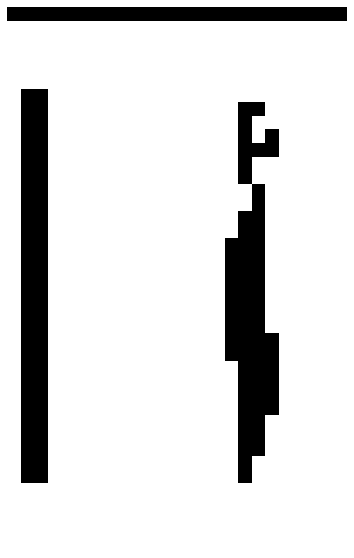

In [12]:
imShow(zones[1][1])

In [11]:
print(text)

37947 أ	6
